In [25]:
import numpy as np
import matplotlib as mpl
from matplotlib.colors import LogNorm, Normalize
import pylab
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

import pickle
import os

%matplotlib inline

In [26]:
plt.rcParams.update({'font.size': 24})

In [27]:
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
mpl.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
mpl.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'

In [4]:
np_load_old = np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

# constants

In [28]:
Emin = 1.6 # min energy
conv = 1e-27*0.389379304 # [GeV*cm^2]<-- conversion factor for xsec[GeV^-2] -> xsec[cm^2]
ice_dens = 1.#  0.93 # g/cm^3

global_path_p = '../../../files/tot_xsec/xsec_quick_start/protons/'
global_path_n = '../../../files/tot_xsec/xsec_quick_start/neutrons/'
files_save_path = '../../../files/tot_xsec/tot_xsec_corrections/isoscalar/'
plots_save_path = '../../../plots/corrections/tot_xsec/'

pth_cuts = '../../../files/tot_xsec/ratios_Q2cut/'

# read .npy files - quick start

In [22]:
g_i = np.load(global_path_n+'genie_ind_n.npy')[0]
g_v = np.load(global_path_n+'genie_totxsec_vars_n.npy')[0]

#~~~~

ind_NuMu_CC_n = g_i['NuMu_CC_O_n']
ind_NuMu_NC_n = g_i['NuMu_NC_O_n']
ind_NuMu_Bar_CC_n = g_i['NuMu_Bar_CC_O_n']
ind_NuMu_Bar_NC_n = g_i['NuMu_Bar_NC_O_n']

lgE_genie_n = g_v['lgE']
xsec_E_genie_n = g_v['xsec_per_E']

In [23]:
g_i = np.load(global_path_p+'genie_ind_p.npy')[0]
g_v = np.load(global_path_p+'genie_totxsec_vars_p.npy')[0]

#~~~~

ind_NuMu_CC_p = g_i['NuMu_CC_O_p']
ind_NuMu_NC_p = g_i['NuMu_NC_O_p']
ind_NuMu_Bar_CC_p = g_i['NuMu_Bar_CC_O_p']
ind_NuMu_Bar_NC_p = g_i['NuMu_Bar_NC_O_p']

lgE_genie_p = g_v['lgE']
xsec_E_genie_p = g_v['xsec_per_E']

# read xsec from .dat files

In [13]:
def read_xsec_from_dat_file(pth, name, ftype = '.dat'):
    
    filename = pth + name + ftype
#     print 'reading file: ', filename
    
    datContent = [i.strip().split() 
                  for i in open(filename).readlines()]
    
    dat_nedges = int(datContent[0][0])
    dat_st_bins = int(datContent[0][2])
    dat_end_bins = int(datContent[0][3])

    dat_lgE_bins = np.linspace(dat_st_bins, dat_end_bins, dat_nedges)
    dat_lgE_bin_centers = dat_lgE_bins[:-1]

    dat_xsec = [float(datContent[i][0]) for i in range(1, len(datContent)-1)]
    dat_xsec = np.array(dat_xsec) * 1.0e-27

    return dat_lgE_bin_centers, dat_xsec

def read_list_xsec_dat_files(pth, names, ftype='.dat'):
    
    d = {}
    for i in range(len(names)):
        name = names[i]
        
        dat_lgE_bin_centers, dat_xsec = read_xsec_from_dat_file(pth, name, ftype=ftype)
        dat_xsec_per_E = dat_xsec/10.**(dat_lgE_bin_centers)
        
        d[name] = {'lgE':dat_lgE_bin_centers, 'xsec':dat_xsec, 'xsec_per_E':dat_xsec_per_E}
        
    return d

In [14]:
pth_csms_dat = '/home/maria/installplace/icetray/build/neutrino-generator/cross_section_data/csms/'
names_csms_dat = ['total_nu_CC_iso_NLO_HERAPDF1.5NLO_EIG', 'total_nu_NC_iso_NLO_HERAPDF1.5NLO_EIG', 
                  'total_nubar_NC_iso_NLO_HERAPDF1.5NLO_EIG', 'total_nubar_CC_iso_NLO_HERAPDF1.5NLO_EIG']

xsec_csms = read_list_xsec_dat_files(pth=pth_csms_dat, names=names_csms_dat)

# ------------------------
# PLOTS corrected by cuts from phase space
# ------------------------

In [18]:
asp_r = 1./12.*6.

left, width = 0.26, 0.84
bottom, height = 0.1, 0.75
bottom_h = bottom + height + 0.02
left_h = left + width + 0.02

rect1 = [left*asp_r, bottom+0.3, width, height-0.2]
rect2 = [left*asp_r, bottom, width, 0.28]

In [34]:
def plot_xsec_corr(il_genie_p=ind_NuMu_CC_p, il_genie_n=ind_NuMu_CC_n,
                  key_csms = 'total_nu_CC_iso_NLO_HERAPDF1.5NLO_EIG',
                  title = 'NuMu CC', save_name = 'NuMu_CC',
                  y_r=[0.,1.e-38],
                  linfit_max_lgE=4.):
    
    fig = plt.figure()
    fig.set_figheight(12)
    fig.set_figwidth(12)
    ax = plt.axes(rect1)

    ax.set_xlim(1.,4.)
    ax.set_ylim(y_r)
    ax.set_title(title + ': isoscalar')
#     ax.set_ylabel('total xsec/E, cm^2/GeV')
    ax.set_ylabel(r'$\mathrm{\sigma_{tot}/E, cm^2/GeV}$')
    plt.xticks(visible=False)

    comm_x = np.linspace(1.,4.0,100)

    # #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    
    ax.plot(xsec_csms[key_csms]['lgE'], 
            xsec_csms[key_csms]['xsec_per_E'],
            lw=3, linestyle=':', color='b', label = 'CSMS (NUGEN)')
    
    x = xsec_csms[key_csms]['lgE']
    y = xsec_csms[key_csms]['xsec_per_E']
    fitpar = np.polyfit(x, y, 9)
    fit_dat_csms = np.polyval(fitpar, comm_x)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    fit_arr_p = []
    for i in range(len(il_genie_p)):

        i_g2 = il_genie_p[i]
        if len(i_g2) > 0:
            x = lgE_genie_p[i_g2]
            y = xsec_E_genie_p[i_g2]#/8.
            fitpar = np.polyfit(x, y, 8)
            fit = np.polyval(fitpar, comm_x)
            fit_arr_p.append(fit)
            
    fit_arr_p = np.array(fit_arr_p)
    sum_fit_p = np.sum(fit_arr_p, axis=0)
    
    fit_arr_n = []
    for i in range(len(il_genie_n)):

        i_g2 = il_genie_n[i]
        if len(i_g2) > 0:
            x = lgE_genie_n[i_g2]
            y = xsec_E_genie_n[i_g2]#/8.
            fitpar = np.polyfit(x, y, 8)
            fit = np.polyval(fitpar, comm_x)
            fit_arr_n.append(fit)

    fit_arr_n = np.array(fit_arr_n)
    sum_fit_n = np.sum(fit_arr_n, axis=0)
    
    sum_fit_iso = (sum_fit_p+sum_fit_n)/2.
    ax.plot(comm_x, sum_fit_iso, linestyle='-', c='red', lw=3, label=r'GENIE, w/o cuts')
    
    fit_xyQ2_p = np.polyval(cut_xyQ2_p, comm_x)
    fit_xyQ2_n = np.polyval(cut_xyQ2_n, comm_x)
    
    sum_fit_iso_cuts = (sum_fit_p*fit_xyQ2_p+sum_fit_n*fit_xyQ2_n)/2.
    
    ax.plot(comm_x, sum_fit_iso_cuts, '--', c='g', lw=3, 
            label=r'GENIE, w/ cut on $\mathrm{Q^2}$')
    
    f = np.polyfit(comm_x, fit_dat_csms/sum_fit_iso_cuts, 7)
    f_v = np.polyval(f, comm_x)
    
    ax.plot(comm_x, sum_fit_iso*f_v, linestyle='-', c='cyan', lw=3, 
            label=r'GENIE, w/o cuts, corrected')
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ax.axvline(1.68, lw=1, linestyle='-', color='k', label='50 GeV')
    ax.grid(color='grey', linestyle='--', linewidth=0.4, alpha=0.5)
    plt.legend(fontsize=15, ncol=2)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    ax2 = plt.axes(rect2)
    ax2.set_xlim(1.,4.)
    ax2.set_ylim(0.75, 1.25)
    ax2.set_yticks([0.8, 0.9, 1.0, 1.1, 1.2])
    ax2.set_xlabel(r'$\mathrm{log10(E), GeV}$')
    ax2.set_ylabel(r'$\mathrm{\sigma_{CSMS} / \sigma_*}$')
    
    ratio_w_cuts = fit_dat_csms/sum_fit_iso_cuts
    
    ax2.plot(comm_x, fit_dat_csms/sum_fit_iso, linestyle='-', c='red', lw=3)
    ax2.plot(comm_x, ratio_w_cuts, '--', c='green', lw=3, 
             label='cut on x>x_min + y>y_min + Q2>Q2_min')    
        
    #~~~~~~~~~~~~~~~
    comm_x_20 = np.linspace(1.,4.0,1000)

    f = np.polyfit(comm_x, ratio_w_cuts, 7)
    f_v = np.polyval(f, comm_x_20)
    #~~~~~~~~~~~~~~~
    i = 22 
    print i, comm_x[i]
    freeze = (fit_dat_csms/sum_fit_iso_cuts)[i]
    print freeze
    #~~~~~~~~~~~~~~~
    ind_linfit_low_en_cut = np.transpose(np.argwhere(comm_x>comm_x[i]))[0]
    ind_linfit0 = np.transpose(np.argwhere(comm_x[ind_linfit_low_en_cut]<linfit_max_lgE))[0]
    ind_linfit = ind_linfit_low_en_cut[ind_linfit0]
    linfit = np.polyfit(comm_x[ind_linfit], ratio_w_cuts[ind_linfit], 1)
    linfit_val = np.polyval(linfit, comm_x)
    ax2.plot(comm_x, linfit_val, c='y')
    linfit_corr = [linfit[0], linfit[1]-(np.polyval(linfit, comm_x[i]) - freeze)]
    linfit_val_corr = np.polyval(linfit_corr, comm_x)
    ax2.plot(comm_x, linfit_val_corr, c='orange')
    #~~~~~~~~~~~~~~~

    ax2.axvline(1.68, lw=1, linestyle='-', color='k')
    ax2.axhline(1.0, lw=3, linestyle=':', color='b')
    ax2.grid(color='grey', linestyle='--', linewidth=0.4, alpha=0.5)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
    
#     save_name = title.replace(' ', '_')
#     save_path_latex = '/home/maria/IceCube/crosssections/fig_latex/total_xsec/low_en/'
#     plt.savefig(save_path_latex+save_name+'_iso_low_en'+'.png', dpi='figure')
#     plt.savefig(save_path_latex+save_name+'_iso_low_en'+'.pdf', dpi='figure')
    plt.show()
    
    return f, freeze, linfit_corr

22 1.6666666666666667
1.0594018527081692


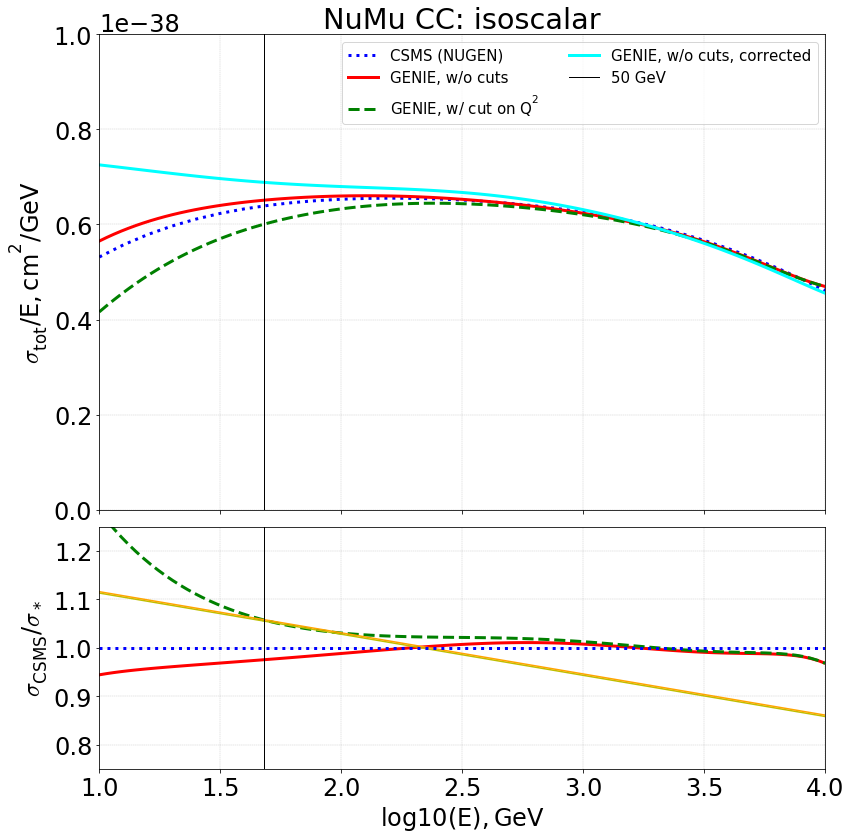

In [35]:
cut_xyQ2_p = np.load(os.path.join(pth_cuts,'ratio_Q2cut_NuMu_CC_protons.npy'))
cut_xyQ2_n = np.load(os.path.join(pth_cuts+'ratio_Q2cut_NuMu_CC_neutrons.npy'))

f, c, l = plot_xsec_corr(il_genie_p=ind_NuMu_CC_p, il_genie_n=ind_NuMu_CC_n,
                      key_csms = 'total_nu_CC_iso_NLO_HERAPDF1.5NLO_EIG',
                      title = 'NuMu CC', save_name = 'NuMu_CC',
                      linfit_max_lgE = 2.)

np.save(os.path.join(files_save_path, '1GeV_interp_NuMu_CC_iso.npy'), 
        [{'poly_coef':f, 'lgE_min':1.68, 'lgEmax':4., 'c':c, 'linear':l}])

22 1.6666666666666667
1.2284160691275534


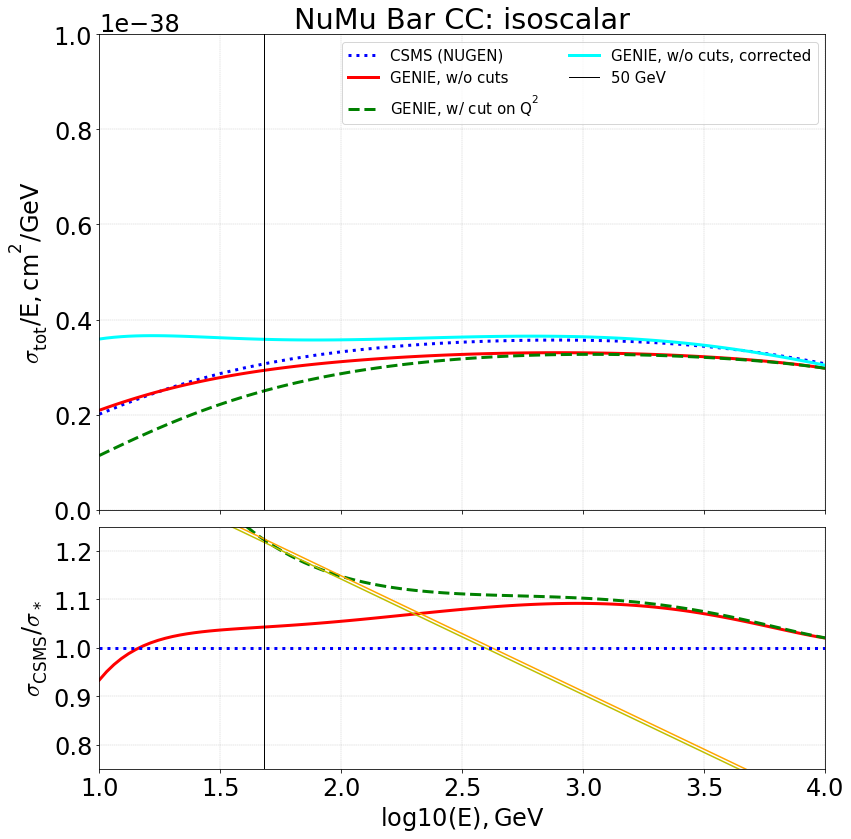

In [36]:
cut_xyQ2_p = np.load(os.path.join(pth_cuts,'ratio_Q2cut_NuMu_Bar_CC_protons.npy'))
cut_xyQ2_n = np.load(os.path.join(pth_cuts+'ratio_Q2cut_NuMu_Bar_CC_neutrons.npy'))

f, c, l = plot_xsec_corr(il_genie_p=ind_NuMu_Bar_CC_p, il_genie_n=ind_NuMu_Bar_CC_n,
                      key_csms = 'total_nubar_CC_iso_NLO_HERAPDF1.5NLO_EIG',
                      title = 'NuMu Bar CC', save_name = 'NuMu_Bar_CC',
                      linfit_max_lgE = 2.)

np.save(os.path.join(files_save_path, '1GeV_interp_NuMu_Bar_CC_iso.npy'), 
        [{'poly_coef':f, 'lgE_min':1.68, 'lgEmax':4., 'c':c, 'linear':l}])

22 1.6666666666666667
0.9752585062310414


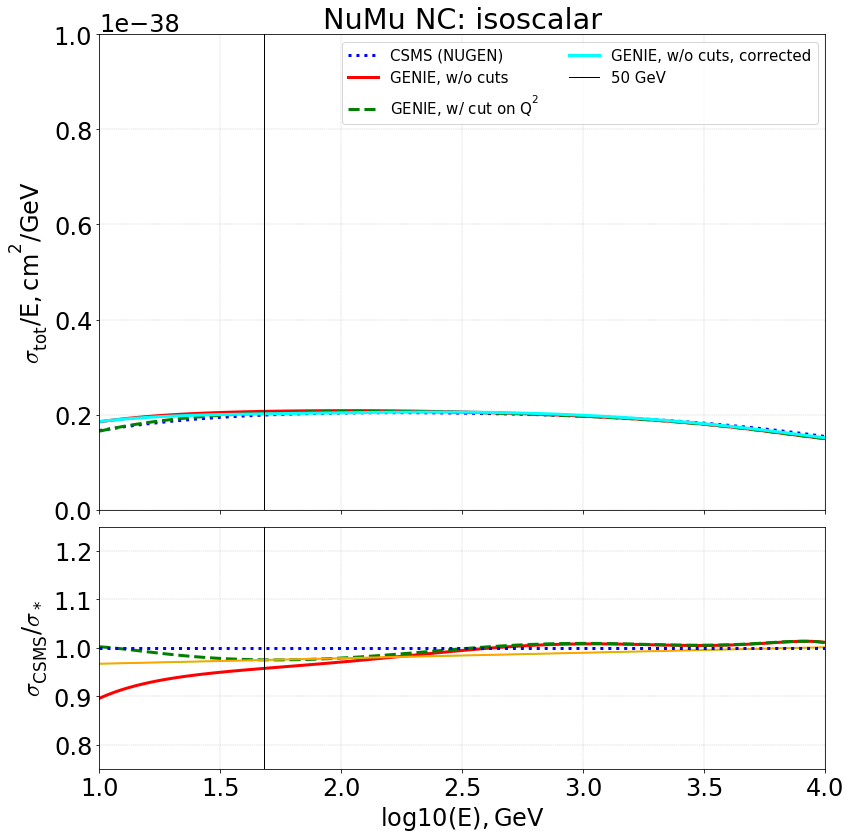

In [37]:
cut_xyQ2_p = np.load(os.path.join(pth_cuts,'ratio_Q2cut_NuMu_NC_protons.npy'))
cut_xyQ2_n = np.load(os.path.join(pth_cuts+'ratio_Q2cut_NuMu_NC_neutrons.npy'))

f, c, l = plot_xsec_corr(il_genie_p=ind_NuMu_NC_p, il_genie_n=ind_NuMu_NC_n,
                      key_csms = 'total_nu_NC_iso_NLO_HERAPDF1.5NLO_EIG',
                      title = 'NuMu NC', save_name = 'NuMu_NC',
                      linfit_max_lgE = 2.)

np.save(os.path.join(files_save_path, '1GeV_interp_NuMu_NC_iso.npy'), 
        [{'poly_coef':f, 'lgE_min':1.68, 'lgEmax':4., 'c':c, 'linear':l}])

22 1.6666666666666667
1.0482225145944029


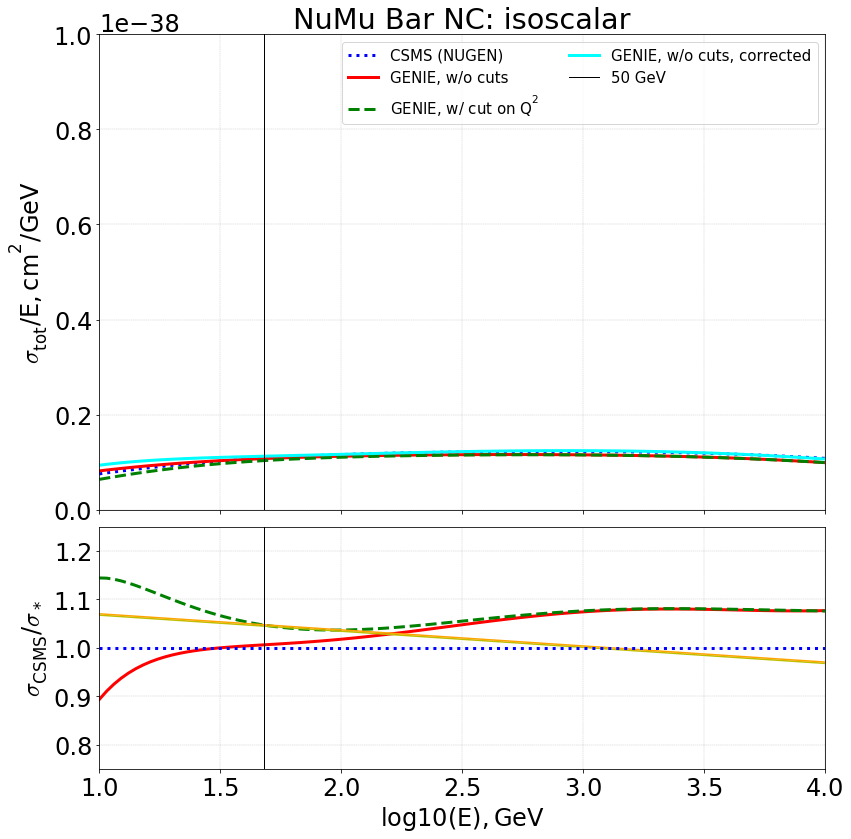

In [38]:
cut_xyQ2_p = np.load(os.path.join(pth_cuts,'ratio_Q2cut_NuMu_Bar_NC_protons.npy'))
cut_xyQ2_n = np.load(os.path.join(pth_cuts+'ratio_Q2cut_NuMu_Bar_NC_neutrons.npy'))

f, c, l = plot_xsec_corr(il_genie_p=ind_NuMu_Bar_NC_p, il_genie_n=ind_NuMu_Bar_NC_n,
                      key_csms = 'total_nubar_NC_iso_NLO_HERAPDF1.5NLO_EIG',
                      title = 'NuMu Bar NC', save_name = 'NuMu_Bar_NC',
                      linfit_max_lgE = 2.)

np.save(os.path.join(files_save_path, '1GeV_interp_NuMu_Bar_NC_iso.npy'), 
        [{'poly_coef':f, 'lgE_min':1.68, 'lgEmax':4., 'c':c, 'linear':l}])